---
syncID: 
title: "Batch Processing Hyperspectral Reflectance Data in Python" 
description: "Learn to work with mulitple reflectance tiles, convert from .h5 to geotiff format, merge geotiff rasters, and plot for a full or partial-site."
dateCreated: 2024-04-20 
authors: Bridget Hass
contributors: Tristan Goulden
estimatedTime: 1 hour
packagesLibraries: h5py, gdal, scikit-image
topics: hyperspectral-remote-sensing, HDF5, remote-sensing, reflectance
languagesTool: Python
dataProduct: DP3.30006.002
code1: https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/tutorials/Python/AOP/Hyperspectral/intro-hyperspectral/intro-refl-h5-fullsite/l3-refl-h5-batch.ipynb
tutorialSeries: 
urlTitle: refl-h5-batch-py
---


In this tutorial, we demonstrate how to batch-process multiple tiles of NEON AOP bidirectional reflectance data (Level 3, tiled) in Python. You will develop and practice skills to explore and visualize the reflectance data and metadata associated with the spectral data over a full site, or part of site, but more than a single tile. Specifically, this demonstrates converting from .h5 format into geotiff raster format, and merging geotiff rasters into a single raster file that will make it easier to work on a larger area of interest.

<div id="ds-objectives" markdown="1">
    
### Learning Objectives

After completing this tutorial, you will be able to:

* Batch process multiple reflectance h5 tiles
* Convert ancillary and reflectance data stored in h5 format into single and multi-band geotiff rasters
* Merge multiple geotiff rasters to create a full-site or partial-site raster
* Visualize (plot) reflectance and ancillary imagery data for full-site or multiple tiles of h5 data


### Install Python Packages

* **gdal** 
* **h5py**
* **requests**
* **gdal**
* **osr**
* **rasterio**
* **scikit-image**

### Download Data

To complete this tutorial, you will download and read in surface directional reflectance data collected at the NEON <a href="https://www.neonscience.org/field-sites/liro" target="_blank">Little Rock Lake (LIRO)</a> site in Wisconsin. This data is downloaded in the first part of the tutorial, using a function that will download data from the NEON data portal using a function that implements the Python requests package to interact with the NEON Data Portal API.

### Additional Resources
More details about the surface directional reflectance data product can be found on the data product page, linked below.
- <a href="https://data.neonscience.org/data-products/DP3.30006.001" target="_blank">Spectrometer orthorectified surface directional reflectance - mosaic</a>
In addition, 
NEON'S Airborne Observation Platform provides Algorithm Theoretical Basis Documents (ATBDs) for all of their data products. Please refer to the ATBDs below for a more in-depth understanding ofthe reflectance datad.- <a href="https://data.neonscience.org/api/v0/documents/NEON.DOC.001288vB?inline=true" target="_blank">NEON Imaging Spectrometer Radiance to Reflectance ATBD</a>
- <a href="https://data.neonscience.org/api/v0/documents/NEON.DOC.004365vB?inline=true" target="_blank">Spectrometer Mosaic ATBD</a>

</div>


## Set up

First let's import the required packages, and write some functions that we'll use to work with this data.

In [1]:
import os, sys
from time import time
import requests
import numpy as np
import h5py
import matplotlib.pyplot as plt
from osgeo import gdal, osr
import rasterio as rio
from rasterio.plot import show
from rasterio.merge import merge
from skimage import exposure

This next function is a handy way to download the Python module and data that we will be using for this lesson. This uses the `requests` package.

In [2]:
# function to download data stored on the internet in a public url to a local file
def download_url(url,download_dir):
    if not os.path.isdir(download_dir):
        os.makedirs(download_dir)
    filename = url.split('/')[-1]
    r = requests.get(url, allow_redirects=True)
    file_object = open(os.path.join(download_dir,filename),'wb')
    file_object.write(r.content)

Download the `neon_aop_hyperspectral` and `aop_download.py` modules from their locations on GitHub to `./python_modules`, add that folder to the path, and import the modules.

In [3]:
hs_module_url = "https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/tutorials/Python/AOP/aop_python_modules/neon_aop_hyperspectral.py"
download_url(hs_module_url,'./python_modules')
aop_download_module_url = "https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/tutorials/Python/AOP/aop_python_modules/neon_aop_download_functions.py"
download_url(aop_download_module_url,'./python_modules')

os.listdir('./python_modules') #optionally show the contents of this directory to confirm the files downloaded

['neon_aop_download_functions.py', 'neon_aop_hyperspectral.py', '__pycache__']

In [23]:
sys.path.insert(0, './python_modules')
import neon_aop_hyperspectral as neon_hs;
import neon_aop_download_functions as aop_dl;

Use the `neon_aop_download_functions` module as follows to download the bidirectional reflectance data at LIRO. First let's check and see what is available at LIRO for this data product (DP3.30006.002). 

In [21]:
dpid = 'DP3.30006.002'
site = 'LIRO'
aop_dl.list_available_urls('DP3.30006.002','LIRO')

['https://data.neonscience.org/api/v0/data/DP3.30006.002/LIRO/2022-06']

We can see that there are bidirectional data available for LIRO in 2022. Now use the `download_aop_files` function to download the 2022 LIRO data. Make sure you have enough space on your computer to download this data. It is ~13.2 GB in size.

In [22]:
aop_dl.download_aop_files(dpid,site,'2022','./data_full_site')

Download size: 13.23 GB


Do you want to continue with the download? (y/n)  n


Exiting download_aop_files


## Batch process reflectance ancillary images: create single-band raster geotiffs and merge
To start, download all of the L3 surface bidiectional reflectance data (DP3.30006.002) at LIRO, which are provided in hdf5 (.h5) format. Use the neon_aop_download_functions (imported as `aop_dl`) to download the data from the cloud storage location. This may take some time since these files are large. Make sure you have enough space, as these files total 12.2 GB in size.

In [5]:
refl_data_tiles = os.listdir('./data_full_site')

First let's read in one of the Ancillary Images, the `Weather_Quality_Indicator` for these tiles and merge them together to create a plot of cloud conditions for the full site. To do this, we'll create a short *data pipeline*, consisting of the following steps:
1. read in reflectance h5 data, extracting only the WQI raster and relevant metadata (i.e. geospatial information)
2. write out the WQI rasters as geotiff rasters
3. merge the raster tiles using `rasterio.merge`
4. plot the full-site raster data

To carry out these steps, we'll need an additional function that's not currently in the `neon_hs` module. This is called `array2raster`, defined below, which reads in an array and relevant geospatial information and writes out a geotiff raster. This function works on a single band, or 2D array.

In [6]:
def array2raster(array,raster_out,raster_origin,pixel_width,pixel_height,epsg):
    """
    Converts a numpy array to a raster file.

    Parameters:
    array (numpy.ndarray): The input 2D array to be converted.
    raster_out (str): The output path for the raster file. Eg. raster_out.tif
    raster_origin (tuple): The (x, y) coordinates for the origin of the raster.
    pixel_width (float): The width of each pixel.
    pixel_height (float): The height of each pixel.
    epsg (int): The EPSG code for the coordinate system.

    Returns:
    None. Writes out a raster array called "raster_out"
    """
    
    cols = array.shape[1]
    rows = array.shape[0]
    x0 = raster_origin[0]
    y0 = raster_origin[1]

    driver = gdal.GetDriverByName('GTiff')
    out_geotiff = driver.Create(raster_out, cols, rows, 1, gdal.GDT_Float32)
    out_geotiff.SetGeoTransform((x0, pixel_width, 0, y0, 0, pixel_height))
    outband = out_geotiff.GetRasterBand(1)
    outband.WriteArray(array)
    out_srs = osr.SpatialReference()
    out_srs.ImportFromEPSG(epsg)
    out_geotiff.SetProjection(out_srs.ExportToWkt())
    outband.FlushCache()

Now that we've defined this function, let's run the first part of the pipeline, which loops through all of the reflectance files in the data folder, and for each file, reads in the weather quality indicator raster from the reflectance data, and writes out a corresponding geotiff, only containing the WQI data. First, create the output folder `data_out/wqi` inside the current working directory.

In [7]:
wqi_outpath = "data_out/wqi"
if not os.path.exists(wqi_outpath):
    os.makedirs(wqi_outpath)

start_time = time()
for refl_file in refl_data_tiles:
    # read the h5 reflectance file (including the full path)f
    h5_tile = os.path.join('data_full_site',refl_file)
    # the WQI geotiffs we're creating will have the same naming structure as the input .h5 files
    # but will end with _wqi.tif instead of bidirectional_reflectance.h5
    out_tif = os.path.join(wqi_outpath,refl_file.replace('bidirectional_reflectance','wqi').replace('.h5','.tif'))
    
    # read in the data using the neon_hs module
    wqi, refl_md, wavelengths = neon_hs.aop_h5refl2array(h5_tile,'Weather_Quality_Indicator')
    # create the WQI rasters using the array2raster function
    array2raster(wqi,out_tif,(refl_md['ext_dict']['xMin'],refl_md['ext_dict']['yMax']),1,-1,refl_md['EPSG'])

# display elapsed time, in minutes
print(f'{round((time() - start_time),2)} seconds')

Reading in  data_full_site\NEON_D05_LIRO_DP3_289000_5094000_bidirectional_reflectance.h5
Reading in  data_full_site\NEON_D05_LIRO_DP3_289000_5095000_bidirectional_reflectance.h5
Reading in  data_full_site\NEON_D05_LIRO_DP3_289000_5096000_bidirectional_reflectance.h5
Reading in  data_full_site\NEON_D05_LIRO_DP3_289000_5097000_bidirectional_reflectance.h5
Reading in  data_full_site\NEON_D05_LIRO_DP3_289000_5098000_bidirectional_reflectance.h5
Reading in  data_full_site\NEON_D05_LIRO_DP3_289000_5099000_bidirectional_reflectance.h5
Reading in  data_full_site\NEON_D05_LIRO_DP3_289000_5100000_bidirectional_reflectance.h5
Reading in  data_full_site\NEON_D05_LIRO_DP3_289000_5101000_bidirectional_reflectance.h5
Reading in  data_full_site\NEON_D05_LIRO_DP3_290000_5094000_bidirectional_reflectance.h5
Reading in  data_full_site\NEON_D05_LIRO_DP3_290000_5095000_bidirectional_reflectance.h5
Reading in  data_full_site\NEON_D05_LIRO_DP3_290000_5096000_bidirectional_reflectance.h5
Reading in  data_full

This next chunk of code reads in all the WQI geotiff files that were generated in the specified output directory as rasterio objects, and uses `rasterio.merge` to merge them into a single geotiff. Finally, we will write out the merged geotiff to a file called `wqi_fullsite.tif`.

In [8]:
# use list comprehension to get a list of the WQI geotiff tiles
wqi_tif_tiles = [os.path.join('./data_out/wqi',file) for file in os.listdir('data_out/wqi') if file.endswith('wqi.tif')]

# create a list of rasterio objects
wqi_tiles_to_mosaic = []
for p in wqi_tif_tiles:
    wqi_raster = rio.open(p)
    wqi_tiles_to_mosaic.append(wqi_raster)

# user rasterio merge to merge all of the 1km tiles into a larger tile
wqi_mosaic, wqi_transform = merge(wqi_tiles_to_mosaic)

# prepare the output metadata
# copy the metadata from one of the 1km x 1km tiles, but update the "transform"
output_meta = wqi_raster.meta.copy()
output_meta.update(
    {"driver": "GTiff",
        "height": wqi_mosaic.shape[1],
        "width": wqi_mosaic.shape[2],
        "transform": wqi_transform,
    }
)

# write out the WQI merged geotiff output file
wqi_out = 'data_out/wqi_fullsite.tif'
with rio.open(wqi_out, "w", **output_meta) as m:
    m.write(wqi_mosaic)

The function below plots the Weather Quality Indicator map. This has some formatting steps to display 1 as green, 2 as yellow, and 3 as red, following the stoplight convention. It also adds a custom colorbar with the cloud cover information.

In [9]:
def plot_wqi(wqi_array,wqi_extent):
    # Create a colormap
    cmap = plt.cm.colors.ListedColormap(['green', 'yellow', 'red'])
    
    # Create a normalized object the describes the limits of each color
    bounds = [0.5, 1.5, 2.5, 3.5]
    norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)
    
    # Plot the data
    plt.imshow(wqi_array, extent=wqi_extent, cmap=cmap, norm=norm)
    ax = plt.gca()
    ax.ticklabel_format(useOffset=False, style='plain'); #do not use scientific notation for ticklabels
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90); #rotate x tick labels 90 degrees
    
    # Create a colorbar
    cbar = plt.colorbar()
    cbar.set_ticks([1, 2, 3])
    cbar.set_ticklabels(['1 (< 10% cloud cover)', '2 (10-50% cloud cover)', '3 (> 50% cloud cover)'])

    plt.title('Weather Quality Map')
    
    plt.show()

### Plot the full-site Weather Quality Indicator raster
Apply the `plot_wqi` function on the data. First filter out values outside of the expected range, which are either No Data Values, or zeros.

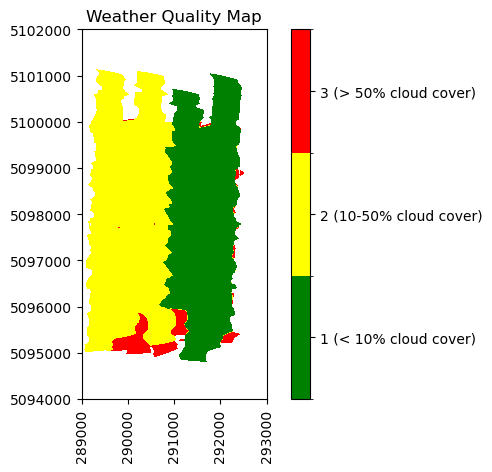

In [10]:
# Plot the Weather Quality Indicator
wqi_fullsite_raster = 'data_out/wqi_fullsite.tif'
# read in the wqi data, usin rasterio (rio)
wqi_data = rio.open(wqi_fullsite_raster)
wqi_array = wqi_data.read(1)

# set anything outside 1,2,3 to NaN (eg. the No Data Value = -9999)
wqi_array[wqi_array > 3] = np.nan
wqi_array[wqi_array < 1] = np.nan
# pull out the extent from the "bounds" of this rasterio object
wqi_extent = (wqi_data.bounds.left, wqi_data.bounds.right, wqi_data.bounds.bottom, wqi_data.bounds.top)

# use the pre-defined function to plot WQI
plot_wqi(wqi_array,wqi_extent)

## Batch process reflectance data: create multi-band raster geotiffs and merge

Let's carry out a similar pipeline, this time creating RGB images from the reflectance files. This may take a little longer, since we are reading in the full hyperspectral data cube from the h5 files. Let's just start with 4 adjacent tiles, to start, but you can expand upon this for the full site. These steps are listed below: 
1. read in the refletance h5 data
2. create a 3-band RGB stack of the data
3. write out the multi-band geotiff files
4. merge the tiff files into a single merged full-site RGB raster
5. plot the merged raster

We'll start by defining a new function, similar to `array2raster` but that works on multiband rasters. Note that we'll have to transpose and un-transpose the data in order to get the dimensions set up correctly for writing out the rasters, and for plotting, later on.

In [11]:
def array2raster_multiband(array, raster_out, raster_origin, pixel_width, pixel_height, epsg):
    """
    Converts a numpy array (n bands x width x height) to a geotiff raster file.

    Parameters:
    array (numpy.ndarray): The input array to be converted. The first dimension should represent the bands.
    raster_out (str): The output path for the raster file.
    raster_origin (tuple): The (x, y) coordinates for the origin of the raster.
    pixel_width (float): The width of each pixel.
    pixel_height (float): The height of each pixel.
    epsg (int): The EPSG code for the coordinate system.

    Returns:
    None
    """
    bands = array.shape[0]
    cols = array.shape[2]
    rows = array.shape[1]
    x0 = raster_origin[0]
    y0 = raster_origin[1]

    driver = gdal.GetDriverByName('GTiff')
    out_geotiff = driver.Create(raster_out, cols, rows, bands, gdal.GDT_Float32)
    out_geotiff.SetGeoTransform((x0, pixel_width, 0, y0, 0, pixel_height))
    
    for b in range(bands):
        outband = out_geotiff.GetRasterBand(b + 1)
        outband.WriteArray(array[b, :, :])

    out_srs = osr.SpatialReference()
    out_srs.ImportFromEPSG(epsg)
    out_geotiff.SetProjection(out_srs.ExportToWkt())
    outband.FlushCache()

In [12]:
rgb_outpath = "data_out/rgb"
if not os.path.exists(rgb_outpath):
    os.makedirs(rgb_outpath)

# optionally read in a subset of the reflectance data tiles, to run faster, can take > 7 minutes to run on all tiles, ~1 minute for 4 tiles
refl_data_tiles = ['NEON_D05_LIRO_DP3_290000_5097000_bidirectional_reflectance.h5',
                   'NEON_D05_LIRO_DP3_290000_5098000_bidirectional_reflectance.h5',
                   'NEON_D05_LIRO_DP3_291000_5097000_bidirectional_reflectance.h5',
                   'NEON_D05_LIRO_DP3_291000_5098000_bidirectional_reflectance.h5']

start_time = time()
for refl_file in refl_data_tiles:
    # read the h5 reflectance file (full path)
    h5_tile = os.path.join("data_full_site",refl_file)
    # the RGB geotiffs we're creating will have the same naming structure as the input .h5 files
    # but will end with _rgb.tif instead of bidirectional_reflectance.h5
    out_tif = os.path.join(rgb_outpath,refl_file.replace('bidirectional_reflectance','rgb').replace('.h5','.tif'))
    
    # read in the data using the neon_hs module
    refl_array, refl_md, wavelengths = neon_hs.aop_h5refl2array(h5_tile,'Reflectance')
    
    # stack the data R, G, and B bands (58, 34, 19) using stack_rgb
    rgb_stack = neon_hs.stack_rgb(refl_array,(58,34,19))
    # transpose the array to change the order of the dimensions required in the array2raster_multiband function
    rgb_transposed = np.transpose(rgb_stack, (2, 0, 1))
    # create the RGB reflectance rasters using the array2raster_multiband function
    # print('Writing out ',os.path.basename(out_tif)) # optionally print out the output geotiff file
    array2raster_multiband(rgb_transposed,out_tif,(refl_md['ext_dict']['xMin'],refl_md['ext_dict']['yMax']),1,-1,refl_md['EPSG'])

# display elapsed time, in minutes
print(f'{round((time() - start_time)/60,1)} minutes')

Reading in  data_full_site\NEON_D05_LIRO_DP3_290000_5097000_bidirectional_reflectance.h5
Reading in  data_full_site\NEON_D05_LIRO_DP3_290000_5098000_bidirectional_reflectance.h5
Reading in  data_full_site\NEON_D05_LIRO_DP3_291000_5097000_bidirectional_reflectance.h5
Reading in  data_full_site\NEON_D05_LIRO_DP3_291000_5098000_bidirectional_reflectance.h5
1.0 minutes


In [13]:
# use list comprehension to get a list of the RGB reflectance geotiff tiles
rgb_tif_tiles = [os.path.join('./data_out/rgb',file) for file in os.listdir('./data_out/rgb') if file.endswith('rgb.tif')]

# create a list of rasterio objects
rgb_tiles_to_mosaic = []
for p in rgb_tif_tiles:
    raster = rio.open(p)
    rgb_tiles_to_mosaic.append(raster)

# user rasterio merge to merge all of the 1km x 1km RGB tiles into a larger tile
mosaic, output_transform = merge(rgb_tiles_to_mosaic)

# rgb_tiles_to_mosaic
print('mosaic shape:',mosaic.shape)

# prepare the output metadata
# copy the metadata from one of the 1km x 1km tiles, but update the "transform"
output_meta = raster.meta.copy()
output_meta.update(
    {"driver": "GTiff",
        "height": mosaic.shape[1],
        "width": mosaic.shape[2],
        "transform": output_transform,
    }
)

# write out the output file - the merged raster geotiff
rgb_fullsite_raster = 'data_out/rgb_refl_fullsite.tif'
with rio.open(rgb_fullsite_raster, "w", **output_meta) as m:
    m.write(mosaic)

mosaic shape: (3, 2000, 2000)


In [14]:
def plot_refl_rgb(rgb_array,ext,ls_pct=5,plot_title=''):   
    # plt.figure(figsize=(10, 12), dpi=80)
    p_low, p_high = np.percentile(rgb_array[~np.isnan(rgb_array)], (ls_pct,100-ls_pct))
    img_rescale = exposure.rescale_intensity(rgb_array, in_range=(p_low,p_high))
    img_rescale = exposure.rescale_intensity(rgb_array, in_range=(p_low,p_high))
    plt.imshow(img_rescale,extent=ext)
    plt.title(plot_title); 
    ax = plt.gca(); ax.ticklabel_format(useOffset=False, style='plain') 
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) 

## Plot the merged RGB reflectance raster

Finally, we'll plot the merged RGB raster for the full site. Note that we need to transpose the data again in order to get the dimensions correct for plotting.

In [15]:
# read in the RGB merged data, using rasterio (rio)
rgb_data = rio.open(rgb_fullsite_raster)
rgb_array = rgb_data.read()
# set the no-data value (-9999) to NaN
rgb_array[rgb_array == -9999.] = np.nan 

RGB array shape, original (3, 2000, 2000)
RGB array shape, transposed (2000, 2000, 3)


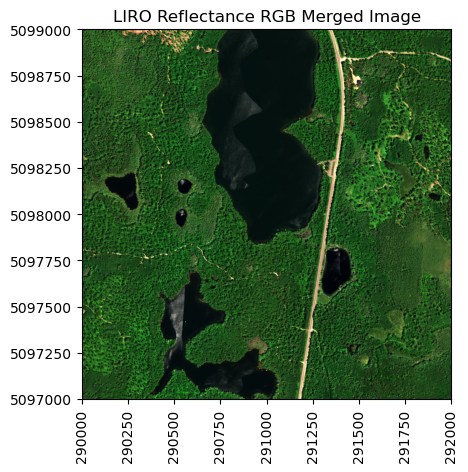

In [16]:
print('RGB array shape, original',rgb_array.shape)
rgb_transposed = np.transpose(rgb_array, (1, 2, 0))
print('RGB array shape, transposed',rgb_transposed.shape)
rgb_merged_extent = (rgb_data.bounds.left, rgb_data.bounds.right, rgb_data.bounds.bottom, rgb_data.bounds.top)
plot_refl_rgb(rgb_transposed,rgb_merged_extent,ls_pct=.2,plot_title="LIRO Reflectance RGB Merged Image")